# Processing the results of the experiment

In [325]:
import importlib
import utils
importlib.reload(utils) # Reload instead of using cached version

# Imports
import pandas as pd
import glob
from pathlib import Path
import os
import subprocess
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Make sure we're using python 3.10.1 (same as version on short)
!python3 --version

Python 3.10.1


## Setup

In [326]:
# Set root to git subfolder
git_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
os.chdir(git_root)

In [327]:
RESULT_DIR = "experiments/results"

Lets first extract all the experiments and trial (folds)

In [328]:
get_root_name = lambda path : path.split("/")[-2]

df = pd.DataFrame()

# Loop through all the search algorithms
search_algorithms = glob.glob(RESULT_DIR + "/*/")
for search_algorithm in search_algorithms:
    rl_algorithms = glob.glob(search_algorithm + "/*/")
    for rl_algorithm in rl_algorithms:
        trial_numbers = glob.glob(rl_algorithm + "/*/")
        for trial_number in trial_numbers:
            path_log = trial_number + "logs/"
            new_row = pd.DataFrame([{"search_algorithm": get_root_name(search_algorithm), "rl_algorithm": get_root_name(rl_algorithm), "trial_number": get_root_name(trial_number).split("_")[-1], "path_log": path_log}])
            df = pd.concat([df, new_row], ignore_index=True)
df

,search_algorithm,rl_algorithm,trial_number,path_log
0,RandomSearch,EpsilonGreedy,0,experiments/results/RandomSearch/EpsilonGreedy...
1,RandomSearch,EpsilonGreedy,1,experiments/results/RandomSearch/EpsilonGreedy...
2,RandomSearch,EpsilonGreedy,2,experiments/results/RandomSearch/EpsilonGreedy...
3,RandomSearch,EpsilonGreedy,3,experiments/results/RandomSearch/EpsilonGreedy...
4,RandomSearch,EpsilonGreedy,4,experiments/results/RandomSearch/EpsilonGreedy...


## Preprocessing

In [329]:
# Columns in tvec.csv: 
# algo_name,algo_name_nice,scenario_name,scenario_name_nice,seed,k,patch,patch_clean,patch_valid,diff,diff_valid,stats_steps,stats_steps_useful,stats_steps_useful_105,log_time_search,log_time_validation,log_time_test,log_time_valid_test,log_time_all,log_time_valid_all,fit_search,fit_training,fit_validation,fit_test,fit_all,fit_valid_training,fit_valid_validation,fit_valid_test,fit_valid_all,fit_init_search,fit_init_training,fit_init_validation,fit_init_test,fit_init_all,fit_init_valid_training,fit_init_valid_validation,fit_init_valid_test,fit_init_valid_all,runtime_test,runtime_all,runtime_valid_test,runtime_valid_all,runtime_init_test,runtime_init_all,runtime_init_valid_test,runtime_init_valid_all,patch_size,patch_clean_size,patch_valid_size,ratio_fit_search,ratio_fit_training,ratio_fit_validation,ratio_fit_test,ratio_fit_all,ratio_fit_valid_training,ratio_fit_valid_validation,ratio_fit_valid_test,ratio_fit_valid_all,ratio_runtime_test,ratio_runtime_all,ratio_runtime_valid_test,ratio_runtime_valid_all,ratio_steps_useful,ratio_steps_useful_105
# TODO: stats_steps,stats_steps_useful,stats_steps_useful_105,log_time_search,log_time_validation,log_time_test,log_time_valid_test,log_time_all,log_time_valid_all,fit_search,fit_training,fit_validation,fit_test,fit_all,fit_valid_training,fit_valid_validation,fit_valid_test,fit_valid_all,fit_init_search,fit_init_training,fit_init_validation,fit_init_test,fit_init_all,fit_init_valid_training,fit_init_valid_validation,fit_init_valid_test,fit_init_valid_all,runtime_test,runtime_all,runtime_valid_test,runtime_valid_all,runtime_init_test,runtime_init_all,runtime_init_valid_test,runtime_init_valid_all,patch_size,patch_clean_size,patch_valid_size,ratio_fit_search,ratio_fit_training,ratio_fit_validation,ratio_fit_test,ratio_fit_all,ratio_fit_valid_training,ratio_fit_valid_validation,ratio_fit_valid_test,ratio_fit_valid_all,ratio_runtime_test,ratio_runtime_all,ratio_runtime_valid_test,ratio_runtime_valid_all,ratio_steps_useful,ratio_steps_useful_105

In [330]:
# Extract Pickle Object
df['pkl_obj'] = df['path_log'].apply(utils.generate_pickle_object)
df['pkl_obj'].iloc[0] # Example of what the pickle object looks like

{'stop': 'time budget',
 'best_patch': <magpie.base.patch.Patch at 0x7f2241adeb30>,
 'initial_patch': <magpie.base.patch.Patch at 0x7f2241adeb30>,
 'initial_fitness': 55206470705,
 'best_fitness': 55206470705,
 'diff': '',
 'warmup_values': [55206465640, 55206472600, 55206470705],
 'operator_selector': <magpie.base.operator_selector.EpsilonGreedy at 0x7f22410d6950>,
 'config': {'possible_edits': [magpie.xml.srcml_edits.DeclStmtReplacement,
   magpie.xml.srcml_edits.ExprStmtReplacement,
   magpie.xml.srcml_edits.IfReplacement,
   magpie.xml.srcml_edits.ReturnReplacement,
   magpie.xml.srcml_edits.DeclStmtInsertion,
   magpie.xml.srcml_edits.ExprStmtInsertion,
   magpie.xml.srcml_edits.IfInsertion,
   magpie.xml.srcml_edits.ReturnInsertion,
   magpie.xml.srcml_edits.DeclStmtDeletion,
   magpie.xml.srcml_edits.ExprStmtDeletion,
   magpie.xml.srcml_edits.IfDeletion,
   magpie.xml.srcml_edits.ReturnDeletion],
  'operator_selector': <magpie.base.operator_selector.EpsilonGreedy at 0x7f22410d6

In [331]:
# Extract some common columns we might need

# df['seed'] = df['pkl_obj'].apply(lambda x: x['seed'])
df['diff'] = df['pkl_obj'].apply(lambda x: x['diff'])
df['initial_fitness'] = df['pkl_obj'].apply(lambda x: x['initial_fitness'])
df['best_fitness'] = df['pkl_obj'].apply(lambda x: x['best_fitness'])
df['patch'] = df['path_log'].apply(utils.get_patch)

In [332]:
df['fitness_decrease_percentage'] = (df['best_fitness'] / df['initial_fitness']) * 100
df.head(7)

,search_algorithm,rl_algorithm,trial_number,path_log,pkl_obj,diff,initial_fitness,best_fitness,patch,fitness_decrease_percentage
0,RandomSearch,EpsilonGreedy,0,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': , 'initi...",,55206470705,55206470705,None,100.000000
1,RandomSearch,EpsilonGreedy,1,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': ExprStmt...",--- before: core/Solver.cc\n+++ after: core/So...,55206499306,55206426960,"ExprStmtDeletion(('core/Solver.cc.xml', 'expr_...",99.999869
2,RandomSearch,EpsilonGreedy,2,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,55206472587,51260893283,"IfDeletion(('core/Solver.cc.xml', 'if', 48))\n",92.853049
3,RandomSearch,EpsilonGreedy,3,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': , 'initi...",,55206458853,55206458853,None,100.000000
4,RandomSearch,EpsilonGreedy,4,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': ReturnRe...",--- before: core/Solver.cc\n+++ after: core/So...,55206470985,51268772056,"ReturnReplacement(('core/Solver.cc.xml', 'retu...",92.867324


## Analysis

### Warmup Consistency

First we explore the variance of the warmup phase. For our experiment, we used to perf function in hopes of minimizing the variance of the warmup phase. The hope is that the variance of the warmup phase is small enough that we can ignore it. We will explore this assumption here.

In [333]:
df['warmup_values'] = df['pkl_obj'].apply(lambda x: np.array(x['warmup_values'])) 

((df['warmup_values'] / df['warmup_values'].apply(lambda x: np.median(x))) - 1) * 100 # Percentage difference from median

0    [-9.174649162613235e-06, 3.4325686293357194e-0...
1    [0.0, -1.3643326057799499e-05, 3.5892525995784...
2    [0.0, -1.132113757185138e-05, 1.13157034187239...
3    [1.55362239073753e-05, 0.0, -1.100233461004407...
4    [4.081043258885586e-06, 0.0, -1.72443549439904...
Name: warmup_values, dtype: object

We notice that the perf function creates values that are very close together. However, there are some significant outliers. We create a boxplot to better visualize the variance of the warmup phase.

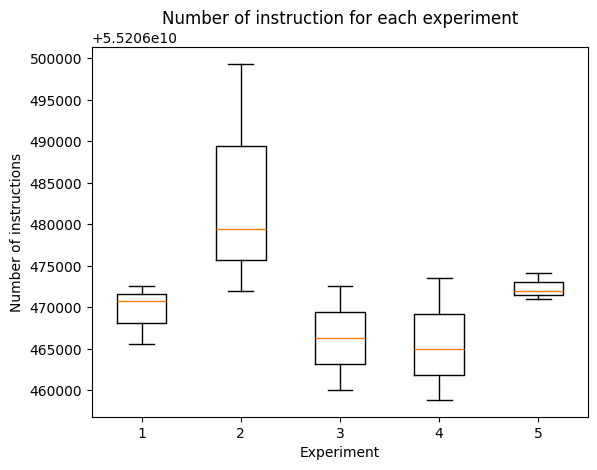

In [334]:
# Creating a boxplot for each experiment
plt.boxplot([df['warmup_values'].iloc[i] for i in range(len(df))])
plt.title('Number of instruction for each experiment')
plt.ylabel('Number of instructions')
plt.xlabel('Experiment')
plt.show()

Each experiment should execute the same number of instructions, so we can combine all the warmup trials.

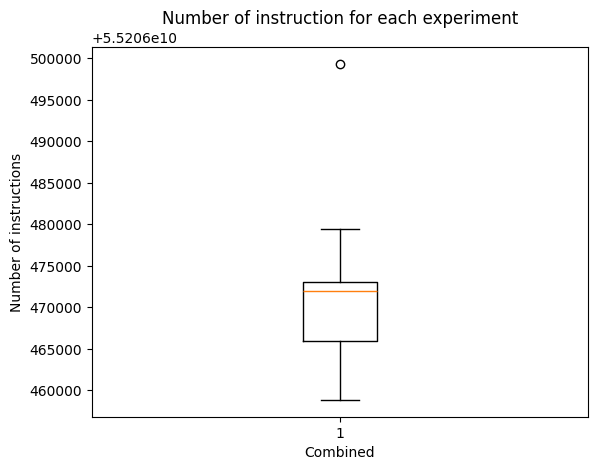

In [335]:
combined_np_array = np.concatenate([df['warmup_values'].iloc[i] for i in range(len(df))])
plt.boxplot(combined_np_array)
plt.title('Number of instruction for each experiment')
plt.ylabel('Number of instructions')
plt.xlabel('Combined')
plt.show()

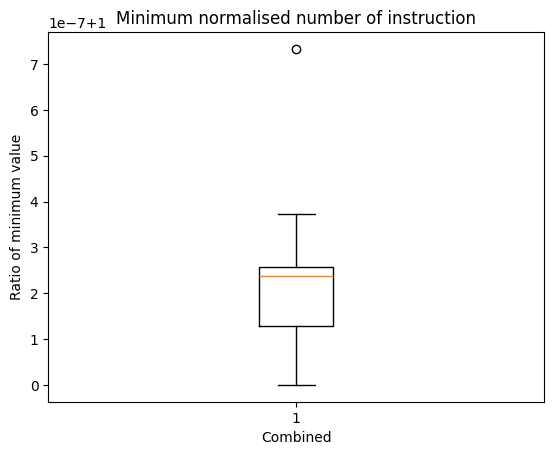

In [336]:
# Let's also normalise by the minimum value
percentage_diff_median = combined_np_array / combined_np_array.min()
plt.boxplot(percentage_diff_median)
plt.title('Minimum normalised number of instruction')
plt.ylabel('Ratio of minimum value')
plt.xlabel('Combined')
plt.show()

We notice that the variance is mostly consistance, however, at times the number of instructions exectued jump up very significantly. We will explore this further in the next section.

In [337]:
combined_np_array

array([55206465640, 55206472600, 55206470705, 55206479491, 55206471959,
       55206499306, 55206466340, 55206460090, 55206472587, 55206473504,
       55206464927, 55206458853, 55206474190, 55206471937, 55206470985])

In [338]:
def get_outliers():
    # Get outliers
    Q1 = np.quantile(combined_np_array, 0.25)
    Q3 = np.quantile(combined_np_array, 0.75)
    IQR = Q3 - Q1
    outliers = combined_np_array[(combined_np_array < Q1 - 1.5 * IQR) | (combined_np_array > Q3 + 1.5 * IQR)]
    return outliers

outliers = get_outliers()

print(f"There are {len(outliers)} outliers, so {len(outliers) * 100 / len(combined_np_array):.2f}% of the data is outliers")

# Percentage difference from median
average_outlier_magnitude = ((outliers / np.median(combined_np_array)) - 1) * 100
if len(average_outlier_magnitude) > 0:
    print(f"Average outlier magnitude: {np.mean(average_outlier_magnitude):.2f}%")

    

There are 1 outliers, so 6.67% of the data is outliers
Average outlier magnitude: 0.00%


This essentially gives use evidence that parallisation will induce very significant noise. As context switching leads to an uptick in instruction count.

### Analyse experiment runs

#### Random Search

We simply compare operators between each other for random search.

In [339]:
df.head(7)

,search_algorithm,rl_algorithm,trial_number,path_log,pkl_obj,diff,initial_fitness,best_fitness,patch,fitness_decrease_percentage,warmup_values
0,RandomSearch,EpsilonGreedy,0,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': , 'initi...",,55206470705,55206470705,None,100.000000,"[55206465640, 55206472600, 55206470705]"
1,RandomSearch,EpsilonGreedy,1,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': ExprStmt...",--- before: core/Solver.cc\n+++ after: core/So...,55206499306,55206426960,"ExprStmtDeletion(('core/Solver.cc.xml', 'expr_...",99.999869,"[55206479491, 55206471959, 55206499306]"
2,RandomSearch,EpsilonGreedy,2,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': IfDeleti...",--- before: core/Solver.cc\n+++ after: core/So...,55206472587,51260893283,"IfDeletion(('core/Solver.cc.xml', 'if', 48))\n",92.853049,"[55206466340, 55206460090, 55206472587]"
3,RandomSearch,EpsilonGreedy,3,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': , 'initi...",,55206458853,55206458853,None,100.000000,"[55206473504, 55206464927, 55206458853]"
4,RandomSearch,EpsilonGreedy,4,experiments/results/RandomSearch/EpsilonGreedy...,"{'stop': 'time budget', 'best_patch': ReturnRe...",--- before: core/Solver.cc\n+++ after: core/So...,55206470985,51268772056,"ReturnReplacement(('core/Solver.cc.xml', 'retu...",92.867324,"[55206474190, 55206471937, 55206470985]"


In [340]:
unique_rl_algos = df['rl_algorithm'].unique()
unique_rl_algos

array(['EpsilonGreedy'], dtype=object)

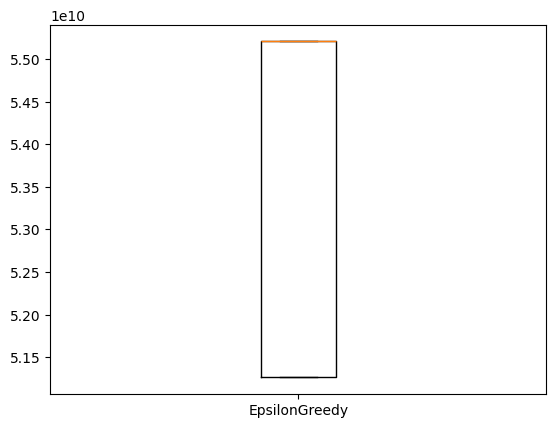

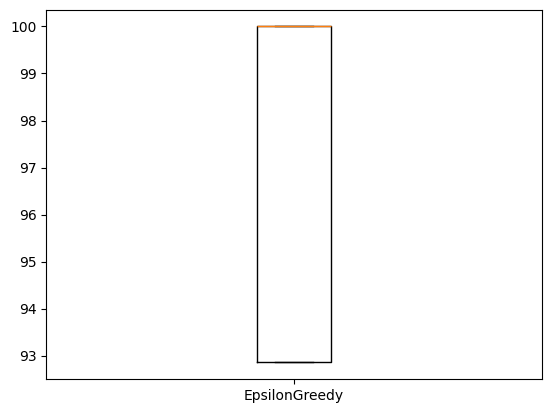

In [341]:
box_mini_plots_best_fitness = []
box_mini_plots_fitness_decrease_percentage = []
for rl_algo_name in unique_rl_algos:
    rl_algo = df[df['rl_algorithm'] == rl_algo_name]

    trail_values_best_fit = np.array(rl_algo['best_fitness'])
    box_mini_plots_best_fitness.append(trail_values_best_fit)

    trail_values_best_fit_percentage = np.array(rl_algo['fitness_decrease_percentage'])
    box_mini_plots_fitness_decrease_percentage.append(trail_values_best_fit_percentage)

plt.boxplot(box_mini_plots_best_fitness, labels=unique_rl_algos)
plt.show()

plt.boxplot(box_mini_plots_fitness_decrease_percentage, labels=unique_rl_algos)
plt.show()



In [342]:
# Median comparison (orange line of box plot)
df.groupby(['rl_algorithm'])['best_fitness'].median().sort_values()

rl_algorithm
EpsilonGreedy    5.520643e+10
Name: best_fitness, dtype: float64

In [343]:
# TODO NTH: rerun the patches (using the revaluate entry point) to validate the best_fitness (but might be best to do this on the validation set)

Quality vs time

TypeError: plot_quality_vs_time() takes 1 positional argument but 2 were given

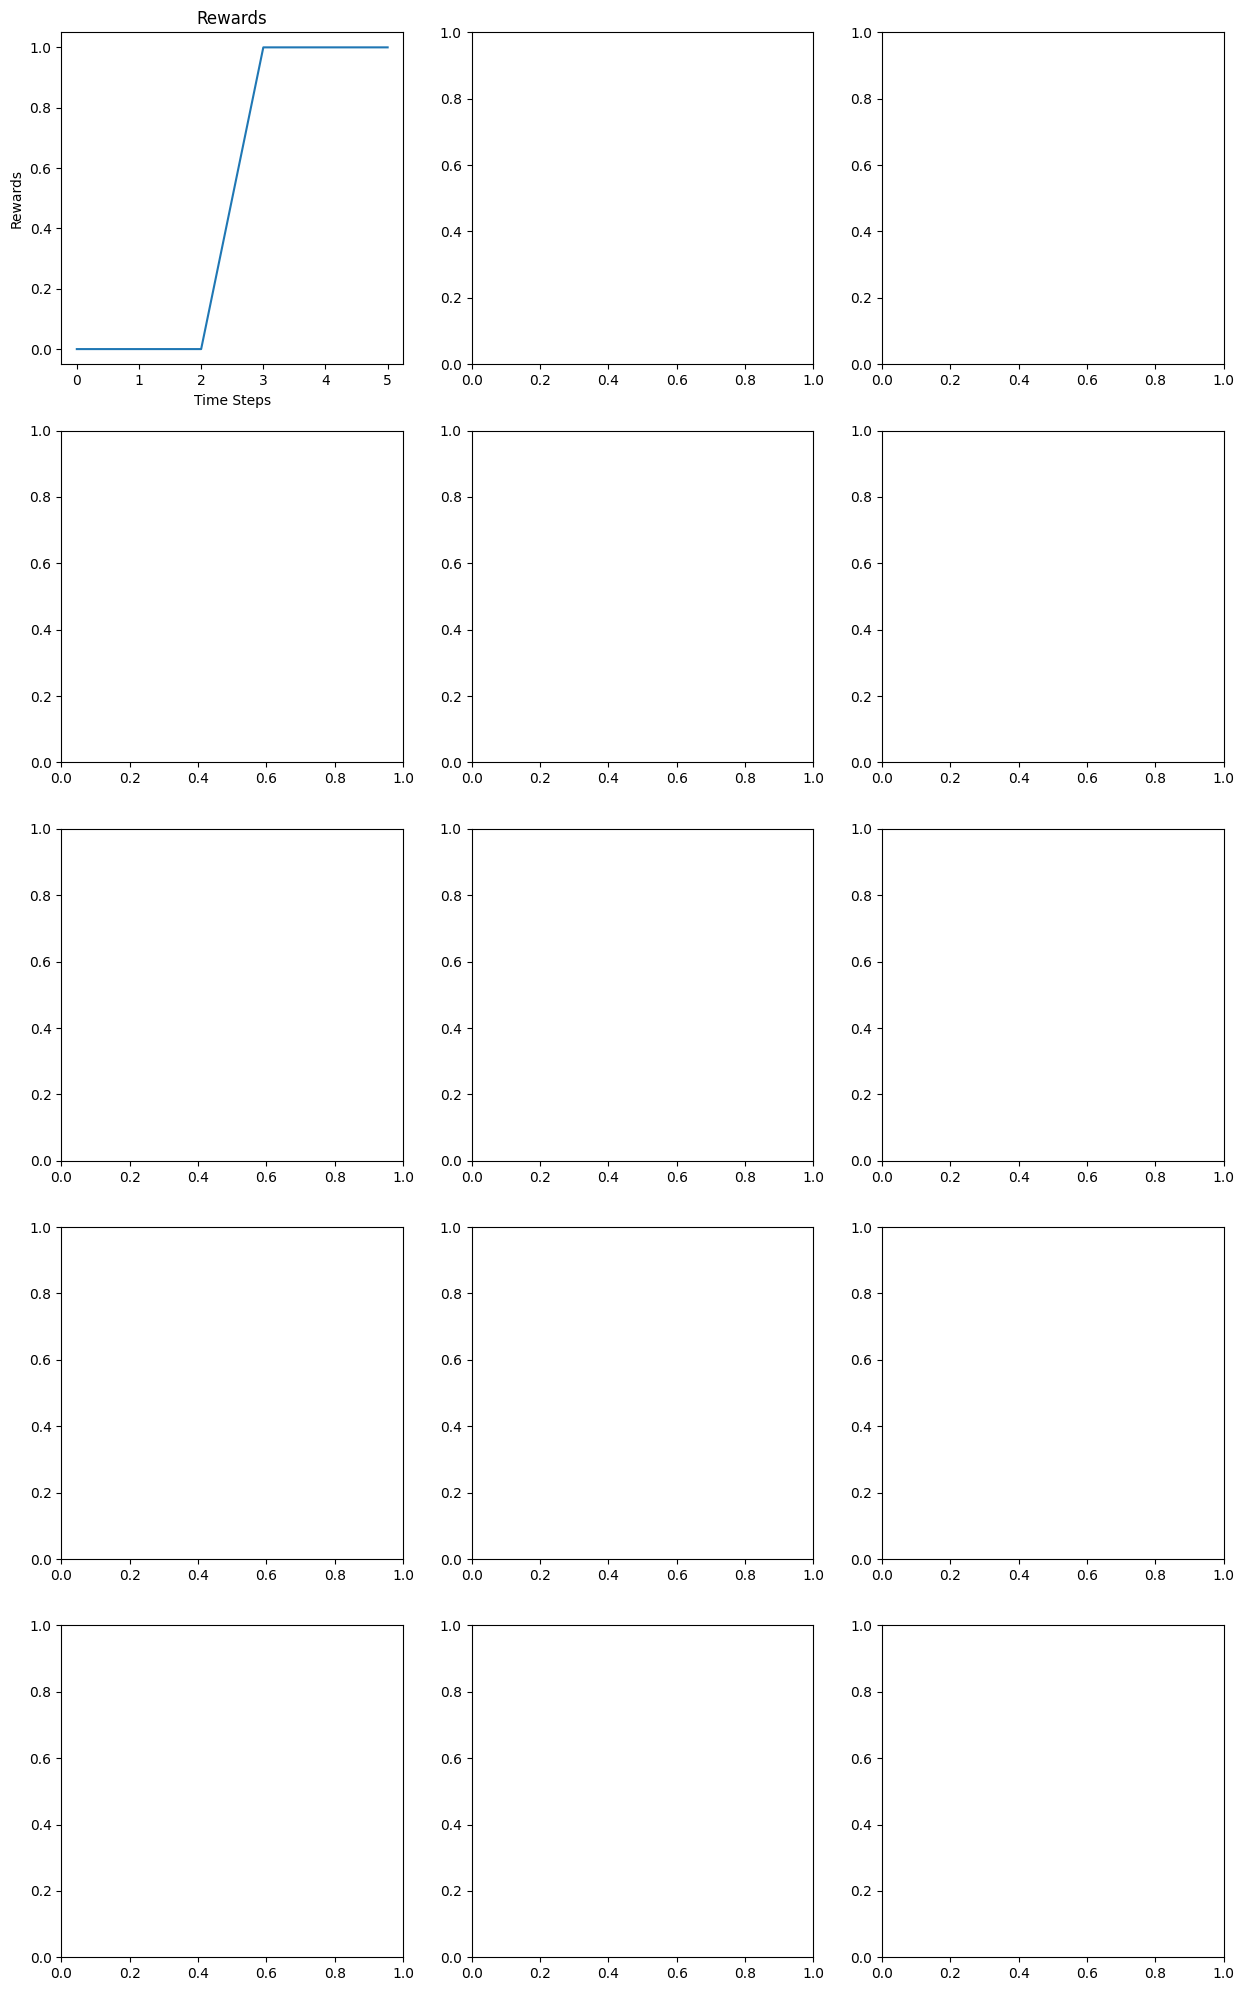

In [344]:
def plot_time_series(series, series_name):
    # Assuming time_steps is a list of time steps corresponding to each reward
    time_steps = list(range(len(series)))

    plt.plot(time_steps, series)
    plt.xlabel('Time Steps')
    plt.ylabel(series_name)
    plt.title(f'{series_name} over Time')
    plt.show()

def plot_quality_vs_time(op_selector):
    fig, ax = plt.subplots(figsize=(10, 5))

    for operator in op_selector._operators:
        ax.plot([average_qualities[operator] for average_qualities in op_selector.average_qualities_log], label=f"{operator.__name__}")

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Quality')
    plt.legend()  # This will add a legend to the plot
    plt.tight_layout()
    plt.show()

def plot_count_vs_time(op_selector):
    fig, ax = plt.subplots(figsize=(10, 5))

    for operator in op_selector._operators:
        ax.plot([action_count[operator] for action_count in op_selector.action_count_log], label=f"{operator.__name__}")

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Count')
    plt.legend()  # This will add a legend to the plot
    plt.tight_layout()
    plt.show()

for i in range(5):
    op_selector = df.iloc[i]['pkl_obj']['operator_selector']
    plot_time_series(op_selector.reward_log, 'Rewards')
    plot_quality_vs_time(op_selector)
    plot_count_vs_time(op_selector)
